<a href="https://colab.research.google.com/github/Davjot/PlantDoc/blob/main/(two_layers%2Cchange)Updated_DN201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changes: 

Dropout:0.2

two layers added : 512 & 256

batch size : 8

epochs : 100

kernel size : 3,3


In [1]:
#import tensorflow.keras.backend as K
#K.clear_session()

In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Concatenate, multiply, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau , TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.applications.densenet import DenseNet201

In [3]:
# define input shape
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

In [4]:
# initialize DenseNet201 model
densenet = DenseNet201(input_tensor=input_tensor, weights='imagenet', include_top=False)

74836368/74836368 [==============================] - 3s 0us/step


In [5]:
# add SE mechanism
se_ratio = 16

In [6]:
def squeeze_excite_block(input, filters):
    se = GlobalAveragePooling2D()(input)
    se = Dense(filters // se_ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return multiply([input, se])

In [7]:
# add Residual Attention Mechanism (RAM)
def residual_attention_block(input, filters, stage):
    conv1 = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    conv2 = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv3 = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    se = squeeze_excite_block(conv3, filters)
    add = Add()([conv3, se])
    res = Activation('relu')(add)

    att = GlobalAveragePooling2D()(res)
    att = Dense(filters // 8, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(att)
    att = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(att)
    att = multiply([res, att])

    return att

In [8]:
# add RAM to DenseNet201
x = densenet.layers[-1].output
x = residual_attention_block(x, 2048, stage='stage_5')

In [9]:
# add classification head
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='softmax')(x)

In [10]:
model = Model(inputs=input_tensor, outputs=x)

In [11]:
# freeze layers
for layer in model.layers[:-4]:
    layer.trainable = False

In [12]:
# compile model
optimizer = Adam(learning_rate=0.001, decay=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Define the data generator for preprocessing the images
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split = 0.2)
#if necessary add validation_split factor =0.2
#val_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import os
base_dir = '/content/drive/MyDrive/Plantdoc'
train_dir = os.path.join(base_dir)
validation_dir = os.path.join(base_dir)
base_dir_testing = '/content/drive/MyDrive/PD_test'
test_dir = os.path.join(base_dir_testing)

In [17]:
#train set
train_apple_leaf_dir = os.path.join(train_dir, 'Apple leaf')
train_apple_rust_leaf_dir = os.path.join(train_dir, 'Apple rust leaf')
train_apple_scab_leaf_dir = os.path.join(train_dir, 'Apple scab leaf')
train_bell_pepper_leaf_dir = os.path.join(train_dir, 'Bell pepper leaf')
train_bell_pepper_leaf_spot_dir = os.path.join(train_dir, 'Bell pepper leaf spot')
train_blueberry_leaf_dir = os.path.join(train_dir, 'Blueberry leaf')
train_cherry_leaf_dir = os.path.join(train_dir, 'Cherry leaf')
train_corn_gray_leaf_spot_dir = os.path.join(train_dir, 'Corn Gray leaf spot')

In [18]:
#validation set
validation_apple_leaf_dir = os.path.join(validation_dir, 'Apple leaf')
validation_apple_rust_leaf_dir = os.path.join(validation_dir, 'Apple rust leaf')
validation_apple_scab_leaf_dir = os.path.join(validation_dir, 'Apple scab leaf')
validation_bell_pepper_leaf_dir = os.path.join(validation_dir, 'Bell pepper leaf')
validation_bell_pepper_leaf_spot_dir = os.path.join(validation_dir, 'Bell pepper leaf spot')
validation_blueberry_leaf_dir = os.path.join(validation_dir, 'Blueberry leaf')
validation_cherry_leaf_dir = os.path.join(validation_dir, 'Cherry leaf')
validation_corn_gray_leaf_spot_dir = os.path.join(validation_dir, 'Corn Gray leaf spot')

In [19]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical')


Found 80 images belonging to 8 classes.


In [20]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical')


Found 80 images belonging to 8 classes.


In [21]:
# add callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='min')
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=0, save_best_only=True)

In [22]:
# fit model
history = model.fit(
    train_generator,
   # steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
   # validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=[early_stop, reduce_lr, checkpointer])

Epoch 1/100
10/10 [==============================] - 126s 11s/step - loss: 4.1940 - accuracy: 0.1750 - val_loss: 3.9064 - val_accuracy: 0.1375 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 88s 9s/step - loss: 4.2561 - accuracy: 0.1875 - val_loss: 3.8570 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 128s 14s/step - loss: 3.7703 - accuracy: 0.2875 - val_loss: 3.8010 - val_accuracy: 0.2125 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 90s 9s/step - loss: 3.7588 - accuracy: 0.3125 - val_loss: 3.7162 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 87s 9s/step - loss: 3.5597 - accuracy: 0.3750 - val_loss: 3.6647 - val_accuracy: 0.2625 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 88s 9s/step - loss: 3.5734 - accuracy: 0.3250 - val_loss: 3.5433 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 87s 9s/step - loss:

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [24]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [25]:
# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

In [26]:
# Get number of epochs
epochs = range(len(acc))

<Figure size 640x480 with 0 Axes>

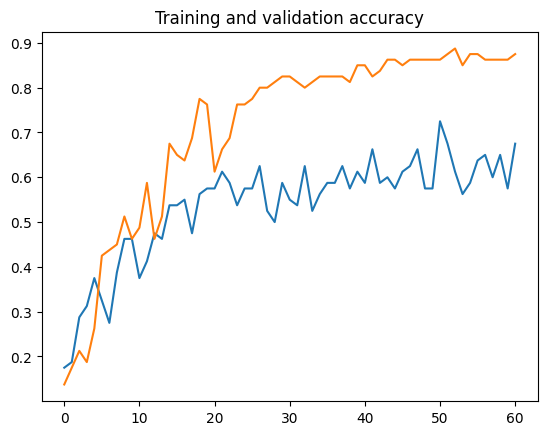

<Figure size 640x480 with 0 Axes>

In [27]:
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

<Figure size 640x480 with 0 Axes>

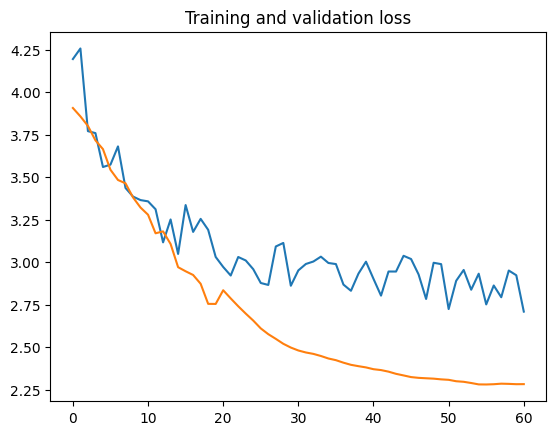

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.figure()

In [29]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical')

Found 71 images belonging to 8 classes.


In [30]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

9/9 [==============================] - 43s 5s/step - loss: 4.3229 - accuracy: 0.3239
Test Loss: 4.322903633117676
Test Accuracy: 0.3239436745643616


In [31]:
from sklearn.metrics import classification_report
import numpy as np
# Predict the labels of the test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate the classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

print(report)

9/9 [==============================] - 39s 4s/step
                       precision    recall  f1-score   support

      Apple Scab leaf       0.00      0.00      0.00        10
           Apple leaf       0.00      0.00      0.00         9
      Apple rust leaf       0.05      0.10      0.06        10
     Bell Pepper leaf       0.00      0.00      0.00         8
Bell pepper leaf spot       0.00      0.00      0.00         9
       Blueberry leaf       0.00      0.00      0.00        11
          Cherry leaf       0.12      0.30      0.17        10
  Corn Gray leaf spot       0.00      0.00      0.00         4

             accuracy                           0.06        71
            macro avg       0.02      0.05      0.03        71
         weighted avg       0.02      0.06      0.03        71



In [32]:
#Make predictions on a single image

from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/drive/MyDrive/Apple leaf.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.
pred = model.predict(img_array)
print(pred) # Predicted probabilities for each class

1/1 [==============================] - 4s 4s/step
[[0.27340338 0.02802547 0.18741302 0.03183311 0.01338675 0.10081536
  0.34872565 0.01639724]]


In [33]:
pred_label = np.argmax(pred)
print('Predicted label:', pred_label)

Predicted label: 6


In [34]:
class_dict = test_generator.class_indices
print('Class dictionary:', class_dict)

Class dictionary: {'Apple Scab leaf': 0, 'Apple leaf': 1, 'Apple rust leaf': 2, 'Bell Pepper leaf': 3, 'Bell pepper leaf spot': 4, 'Blueberry leaf': 5, 'Cherry leaf': 6, 'Corn Gray leaf spot': 7}


In [35]:
pred_class = list(class_dict.keys())[list(class_dict.values()).index(pred_label)]
print('Predicted class:', pred_class)

Predicted class: Cherry leaf
